In [54]:
#run this command if not installed
#!pip install dimod

### Required Modules

In [55]:
#to visualize the network and easy handling of graphs I am using networkx
import networkx as gp
import matplotlib.pyplot as plt
import dimod

In [56]:
#using inbuilt function to find shortest path
#help(gp.shortest_simple_paths)

In [57]:
#we will use pairwise function to convert the continuous nodes (representing path) into edges (where each edge is a node pair)
l= [1,2,4,5,2,4]
ed = list(gp.utils.pairwise(l))
print(ed)

[(1, 2), (2, 4), (4, 5), (5, 2), (2, 4)]


### Sample Input Data

In [103]:
#sample data - to be read from file
#total number of nodes
num_nodes = 6
#Edges are given as u,v,congestion where edges is from u to v and its congestion level is given by the attribute congestion
edges = [
    (0,1,{'congestion':1000}),
    (0,2,{'congestion':1}),
    (1,3,{'congestion':200}),
    (1,4,{'congestion':110}),
    (2,4,{'congestion':10}),
    (2,5,{'congestion':4}),
    (3,4,{'congestion':2}),
    (4,2,{'congestion':54}),
    (0,5,{'congestion':200}),
    (0,3,{'congestion':50})
]
#total number of cars to reroute
no_of_cars = 2
#source-destination pair of each car
src_dest = [(0,4),(0,5)]

## Graph formation using NetworkX

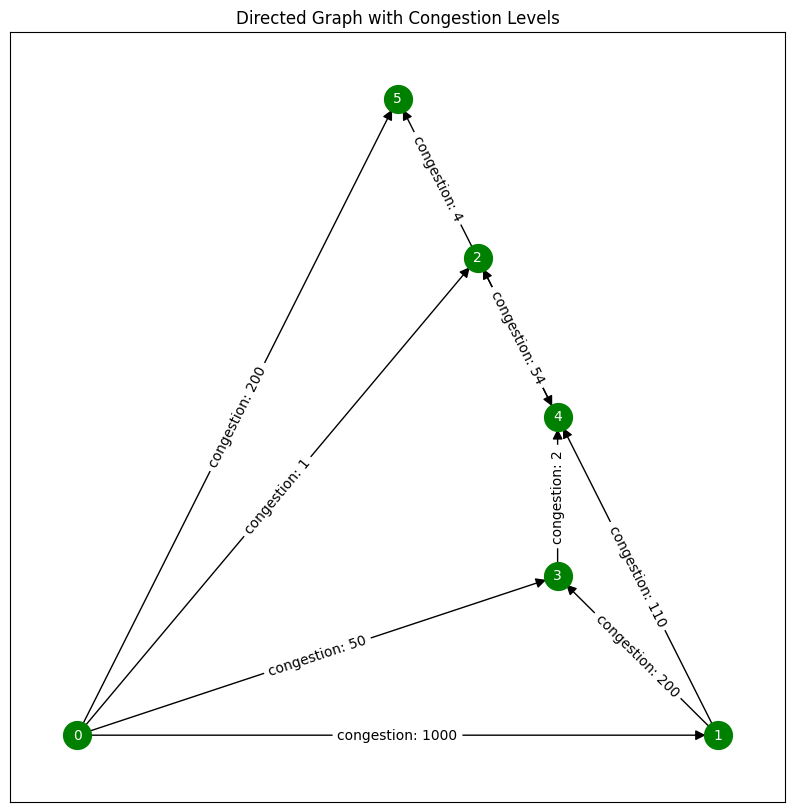

In [104]:
#forming the city's network
#adding nodes
net = gp.DiGraph()
net.add_edges_from(edges)
plt.figure(figsize=(10,10))
pos = gp.planar_layout(net)
gp.draw_networkx_nodes(net, pos, node_color='green', node_size=400)
gp.draw_networkx_edges(net, pos, arrowstyle='-|>', arrowsize=15)
edge_labels = {(u, v): f'congestion: {d["congestion"]}' for u, v, d in net.edges(data=True)}
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels)
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white')
plt.title("Directed Graph with Congestion Levels")
plt.show()

### Alternative Routes

In [105]:
def nodeToEdge(node_routes,no_of_car, no_of_route):
    '''the function convert the route in nodes format to edge format (pairwise nodes as shown above)'''
    edge_route = []
    for i in range(no_of_car):
        car_route = []
        for j in range(no_of_route):
                car_route.append(list(gp.utils.pairwise(node_routes[i][j])))
        edge_route.append(car_route)
    return edge_route

In [106]:
def calcJCS(set_a, set_b):
    '''
    the function calculates the jaccard similarity index of two given paths
    '''
    inter = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return inter/union if union !=0 else 0
def jaccardSimilarityIndex(paths):
    '''
    the function returns the three paths which have least Jaccard Similarity index
    '''
    k = len(paths)
    route = [paths]
    route = nodeToEdge(route,1,k)
    route = route[0]
    result = {}
    for i in range(k):
        for j in range(i+1,k):
            set_a = set(route[i])
            set_b = set(route[j])
            similarity = calcJCS(set_a, set_b)
            result.update({(i,j):similarity})
    srf = sorted(result.items(), key=lambda x: x[1])
    sr=srf[0][0]
    sr2 = srf[1][0]
    final_paths = [paths[sr[0]],paths[sr[1]]]
    if sr2[0] not in sr:
        final_paths.append(paths[sr2[0]])
    else:
        final_paths.append(paths[sr2[1]])
    return final_paths
            
def alternativeRoutes(no_of_cars, sd):
    '''finds all the simple paths from source to destination for each car'''
    routes = []
    for i in range(no_of_cars):
        k_paths = list(gp.shortest_simple_paths(net, source = sd[i][0], target=sd[i][1], weight = 'congestion'))
        k_paths = jaccardSimilarityIndex(k_paths)
        routes.append(k_paths)
    return routes
    #return [[[0,1,4],[0,1,3,4],[0,2,4]],[[0,2,5],[0,1,3,4,5],[0,1,4,5]]]

In [107]:
routes  = alternativeRoutes(no_of_cars,src_dest )
print("Source-Destination Pairs for Rerouting:")
for src, dest in src_dest:
    print(f"Car starting from {src} to {dest}")
print('\nAlternative Routes :\n')
index = 0
for i in range(1,3):
    print(f'Possible Routes for Car {i}')
    for ch in range(0,len(routes[0])):
        l=[]
        for path in routes[i-1][ch]:
            l.append(str(path))
        c="->"
        print(index,":",c.join(l))
        index+=1
        print()

Source-Destination Pairs for Rerouting:
Car starting from 0 to 4
Car starting from 0 to 5

Alternative Routes :

Possible Routes for Car 1
0 : 0->2->4

1 : 0->3->4

2 : 0->1->4

Possible Routes for Car 2
3 : 0->2->5

4 : 0->5

5 : 0->3->4->2->5



### Helping Functions

In [108]:
def getOverlappingEdges(route1, route2):
    '''the function returns a list of overlapping edges (pairwise-nodes)'''
    overlaps =[]
    for r1 in route1:
        if r1 in route2:
            overlaps.append(r1)
    return overlaps

In [109]:
def getNonOverlappingEdges(route):
    uni = []
    for edge in route:
        if edge not in uni:
            uni.append(edge)
    return uni

In [110]:
def matrixWeight(routes, no_of_car, no_of_routes):
        Q_weight ={}
        tot_var = no_of_car * no_of_routes
        for i in range(tot_var):
            for j in range(tot_var):
                #currently assigning weight 1 to all the variables
                Q_weight.update({(i,j):1})
        return Q_weight

In [111]:
def displayMatrix(Q):
    print("-"*50)
    for i in range(0,6):
        for j in range(0,6):
            print(Q.get((i,j)),"\t|", end=" ")
        print()
        print("-"*50)
    print()

In [112]:
def formQuboMatrix(routes, no_of_car, no_of_routes):
    '''function to form the QUBO matrix in the form of dictionary'''
    #dictionary Q will store the qubo matrix
    Q = {}
    K = 0 # initializing penalty factor
    W = matrixWeight(routes, no_of_car, no_of_routes)
    tot_var = no_of_car*no_of_routes
    #initializing the matrix values to 0
    for i in range(tot_var):
        for j in range(tot_var):
            Q.update({(i,j):0})
    #adding cost function terms
    for i in range(no_of_car):
        car_i_overlap = 0;
        for j in range(no_of_routes):
            tot_overlap = []
            for k in range(i+1, no_of_car):
                for m in range(no_of_routes):
                    list_of_overlap = getOverlappingEdges(routes[i][j], routes[k][m])
                    #print(list_of_overlap)
                    Q.update({(i*no_of_routes + j, k*no_of_routes + m):2*len(list_of_overlap)*W[(i,j)]*W[(k,m)]})
                    tot_overlap.extend(list_of_overlap)
            uni_overlap = getNonOverlappingEdges(tot_overlap)
            Q.update({(i*no_of_routes + j, i*no_of_routes + j):len(tot_overlap)*W[(i,j)]*W[(i,j)]})
            car_i_overlap += len(uni_overlap)
        K = max(K, car_i_overlap)
        
    #adding penalty terms
    for i in range(no_of_car):
        for j in range(no_of_routes):
            for m in range(j+1, no_of_routes):
                Q.update({(i*no_of_routes + j, i*no_of_routes + m):K*2})
            Q[(i*no_of_routes + j, i*no_of_routes + j)] -= K;
    return Q    

In [113]:
routes  = alternativeRoutes(no_of_cars,src_dest)
no_of_routes = len(routes[0])
routes_edge = nodeToEdge(routes,no_of_cars,no_of_routes)
Q = formQuboMatrix(routes_edge, no_of_cars, no_of_routes)
#Q will be an upper triangle matrix
print("QUBO Matrix : for 2 cars and 3 alternative route ( 6 x 6 matrix)")
displayMatrix(Q)

QUBO Matrix : for 2 cars and 3 alternative route ( 6 x 6 matrix)
--------------------------------------------------
-2 	| 6 	| 6 	| 2 	| 0 	| 0 	| 
--------------------------------------------------
0 	| -1 	| 6 	| 0 	| 0 	| 4 	| 
--------------------------------------------------
0 	| 0 	| -3 	| 0 	| 0 	| 0 	| 
--------------------------------------------------
0 	| 0 	| 0 	| -3 	| 6 	| 6 	| 
--------------------------------------------------
0 	| 0 	| 0 	| 0 	| -3 	| 6 	| 
--------------------------------------------------
0 	| 0 	| 0 	| 0 	| 0 	| -3 	| 
--------------------------------------------------



In [114]:
#runnign the classical solver 
bqm = dimod.BinaryQuadraticModel.from_qubo(Q)
exact_solver  = dimod.ExactSolver()
response = exact_solver.sample(bqm)
result = list(response.samples())
print(response)
resulting_energy = list(response.data_vectors['energy'])
min_energy = min(resulting_energy)
ct = resulting_energy.count(min_energy)
best_result = []
for i in range(ct):
    best_result.append(list(dict.values(dict(result[i]))))

    0  1  2  3  4  5 energy num_oc.
8   0  0  1  1  0  0   -6.0       1
24  0  0  1  0  1  0   -6.0       1
56  0  0  1  0  0  1   -6.0       1
30  1  0  0  0  1  0   -5.0       1
62  1  0  0  0  0  1   -5.0       1
12  0  1  0  1  0  0   -4.0       1
28  0  1  0  0  1  0   -4.0       1
7   0  0  1  0  0  0   -3.0       1
14  1  0  0  1  0  0   -3.0       1
15  0  0  0  1  0  0   -3.0       1
23  0  0  1  1  1  0   -3.0       1
31  0  0  0  0  1  0   -3.0       1
39  0  0  1  0  1  1   -3.0       1
55  0  0  1  1  0  1   -3.0       1
63  0  0  0  0  0  1   -3.0       1
1   1  0  0  0  0  0   -2.0       1
25  1  0  1  0  1  0   -2.0       1
33  1  0  0  0  1  1   -2.0       1
57  1  0  1  0  0  1   -2.0       1
3   0  1  0  0  0  0   -1.0       1
11  0  1  1  1  0  0   -1.0       1
19  0  1  0  1  1  0   -1.0       1
27  0  1  1  0  1  0   -1.0       1
0   0  0  0  0  0  0    0.0       1
9   1  0  1  1  0  0    0.0       1
16  0  0  0  1  1  0    0.0       1
17  1  0  0  1  1  0    0.0 

In [118]:
print("minimum energy :",min_energy)
car1_nodes = []
car2_nodes = []
for sol in best_result:
    print("Possible Solution :", sol)
    ind = 0
    for i in range(no_of_cars):
        for j in range(no_of_routes):
            if(sol[ind]==1):
                    print(f'best route for car {i+1}: {routes[i][j]}')
                    if(i==0):car1_nodes = routes[i][j]
                    if(i==1):car2_nodes = routes[i][j]
            ind+=1

minimum energy : -6.0
Possible Solution : [0, 0, 1, 0, 0, 1]
best route for car 1: [0, 1, 4]
best route for car 2: [0, 3, 4, 2, 5]
Possible Solution : [0, 0, 1, 0, 1, 0]
best route for car 1: [0, 1, 4]
best route for car 2: [0, 5]
Possible Solution : [0, 0, 1, 1, 0, 0]
best route for car 1: [0, 1, 4]
best route for car 2: [0, 2, 5]


Blue represent Car 1 , Green represents Car 2


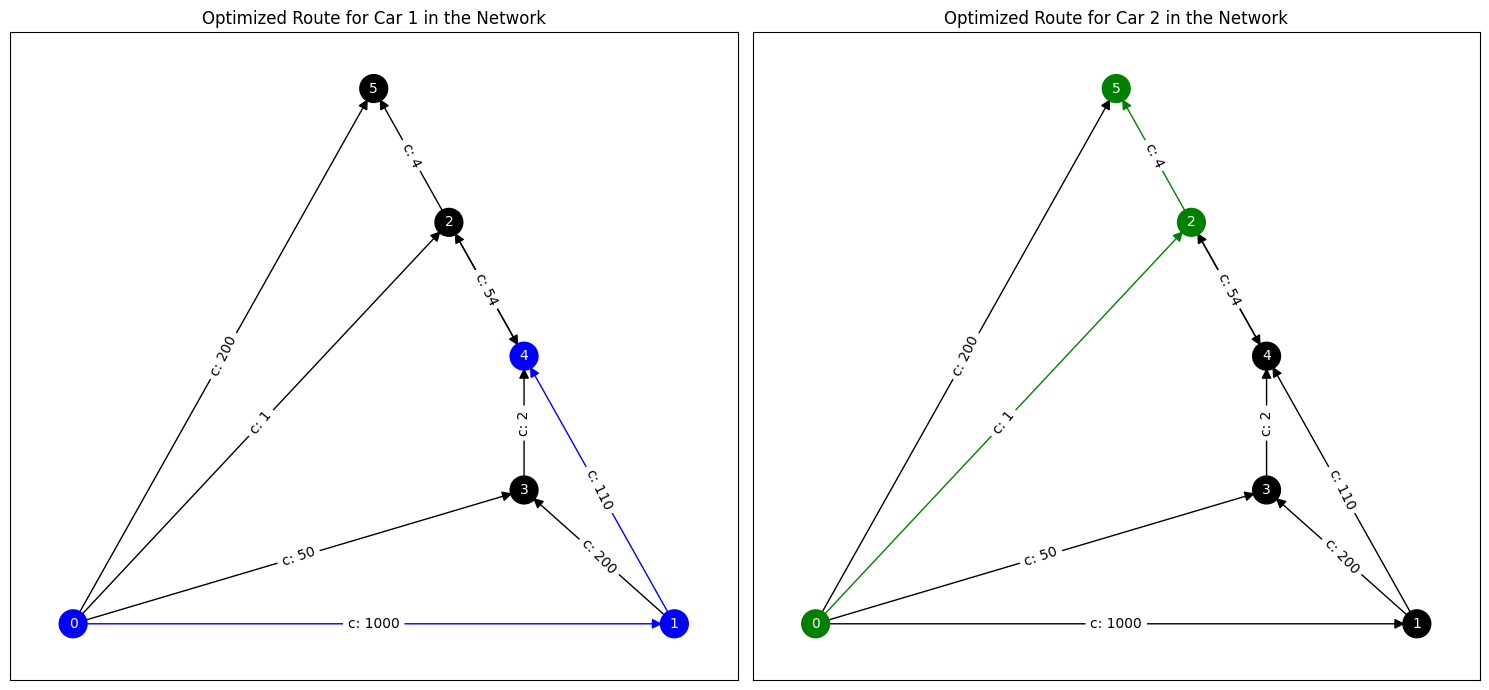

In [120]:
print("Blue represent Car 1 , Green represents Car 2")
car1_edges = list(gp.utils.pairwise(car1_nodes))
car2_edges = list(gp.utils.pairwise(car2_nodes))
edge_labels = {(u, v): f'c: {d["congestion"]}' for u, v, d in net.edges(data=True)}
fig, axes = plt.subplots(1, 2, figsize=(15, 7)) 
pos = gp.planar_layout(net)
#car1
node_colors = ['blue' if node in car1_nodes else 'black' for node in net.nodes()]
edge_colors = ['blue' if (u, v) in car1_edges else 'black' for u, v in net.edges()]
gp.draw_networkx_nodes(net, pos, node_color=node_colors, node_size=400,ax=axes[0])
gp.draw_networkx_edges(net, pos, edge_color = edge_colors, arrowstyle='-|>', arrowsize=15,ax=axes[0])
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels,ax=axes[0])
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white',ax=axes[0])
axes[0].set_title("Optimized Route for Car 1 in the Network")

#car2
node_colors_car2 = ['green' if node in car2_nodes else 'black' for node in net.nodes()]
edge_colors_car2 = ['green' if (u, v) in car2_edges else 'black' for u, v in net.edges()]

gp.draw_networkx_nodes(net, pos, node_color=node_colors_car2, node_size=400, ax=axes[1])
gp.draw_networkx_edges(net, pos, edge_color=edge_colors_car2, arrowstyle='-|>', arrowsize=15, ax=axes[1])
gp.draw_networkx_edge_labels(net, pos, edge_labels=edge_labels,ax=axes[1])
gp.draw_networkx_labels(net, pos, font_size=10, font_color='white',ax=axes[1])
axes[1].set_title("Optimized Route for Car 2 in the Network")


plt.tight_layout()
plt.show()